In [1]:
import numpy as np
import pandas as pd
import scipy as sci
import sklearn as skl
import matplotlib.pyplot as plt
from re import sub
import seaborn as sns

In [2]:
rw_df = pd.read_csv("wine+quality/winequality-red.csv", sep=';')
ww_df = pd.read_csv("wine+quality/winequality-white.csv", sep=';')

### Here I will be trying to predict the quality of the White wine, given other features
I'll check the data first

In [3]:
ww_df.shape

(4898, 12)

In [4]:
ww_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


10 different columns apart from quality, might need to narrow some down and choose which effect quality the most

In [5]:
ww_df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Very fortunate for us, very happy and clean dataset, all the same data type, and all non-NA.
I'll do a pairplot to visualize the features to see if I can't identify any trends.

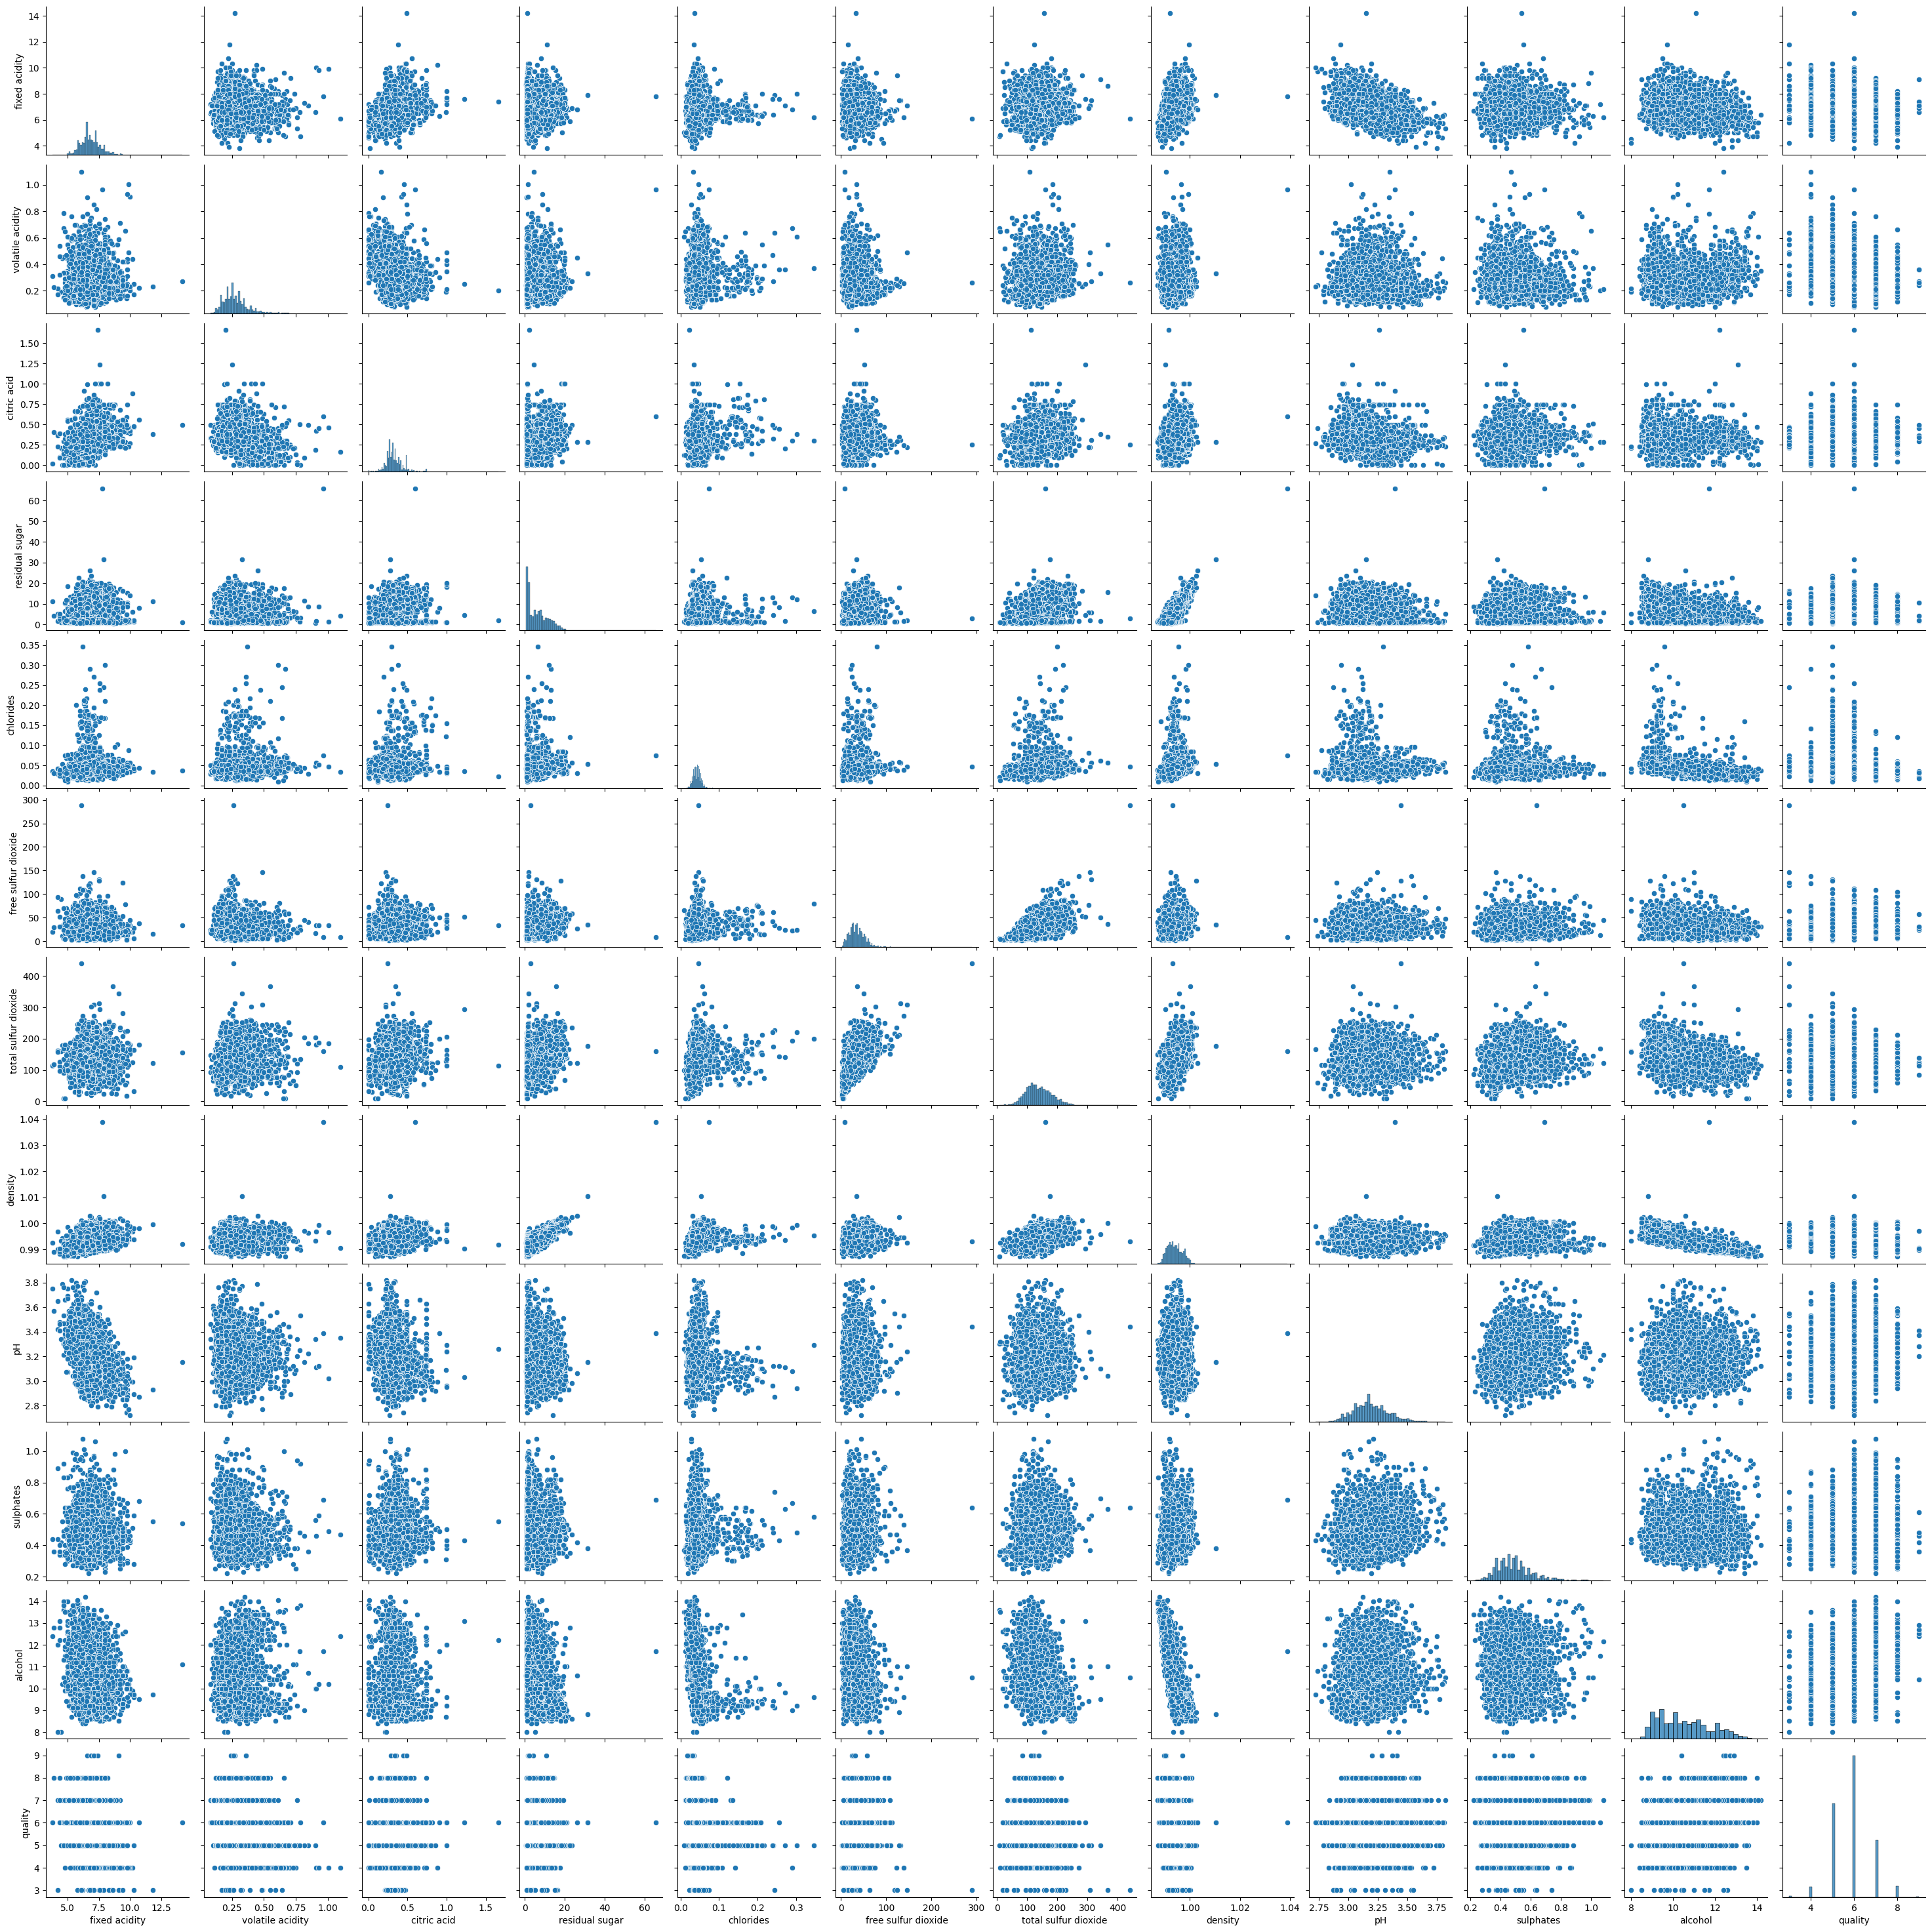

In [6]:
sns.pairplot(ww_df)

In [7]:
# Since we're finding quality, it'll be helpful to see how other elements compare at that quality.
q_df = ww_df.groupby("quality").mean()
q_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  \
quality                                                                 
3             7.600000          0.333250     0.336000        6.392500   
4             7.129448          0.381227     0.304233        4.628221   
5             6.933974          0.302011     0.337653        7.334969   
6             6.837671          0.260564     0.338025        6.441606   
7             6.734716          0.262767     0.325625        5.186477   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
quality                                                                   
3         0.054300            53.325000            170.600000  0.994884   
4         0.050098            23.358896            125.279141  0.994277   
5         0.051546            36.432052            150.904598  0.995263   
6         0.045217            35.650591            137.047316  0.993961   
7         0.038191            34.125568            125.114773  0.992452   

               pH  sulphates    alcohol  
quality                                  
3        3.187500   0.474500  10.345000  
4        3.182883   0.476135  10.152454  
5        3.168833   0.482203   9.808840  
6        3.188599   0.491106  10.575372  
7        3.213898   0.503102  11.367936

<Axes: xlabel='quality'>

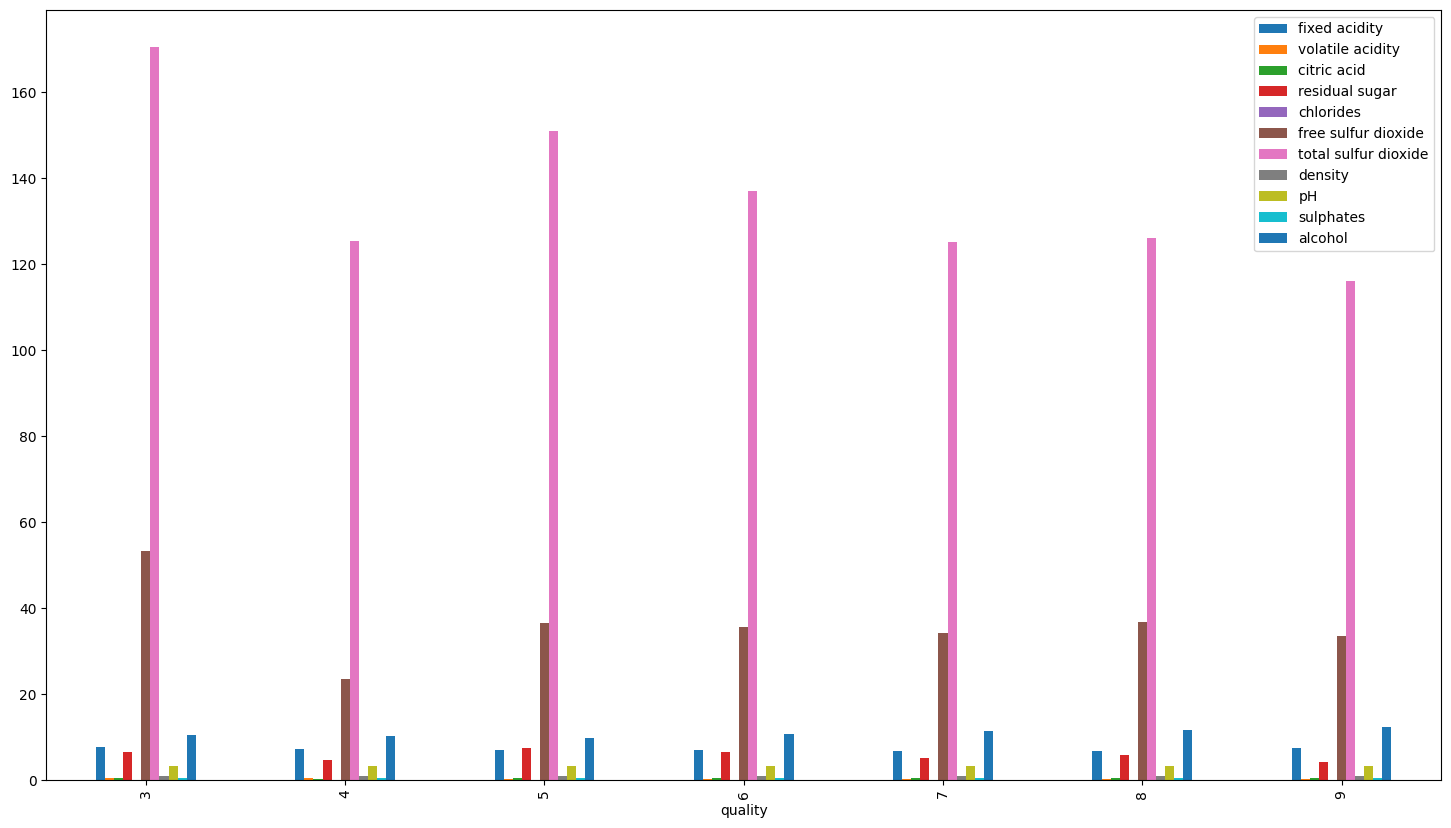

In [8]:
q_df.plot(kind="bar",figsize=(18,10))

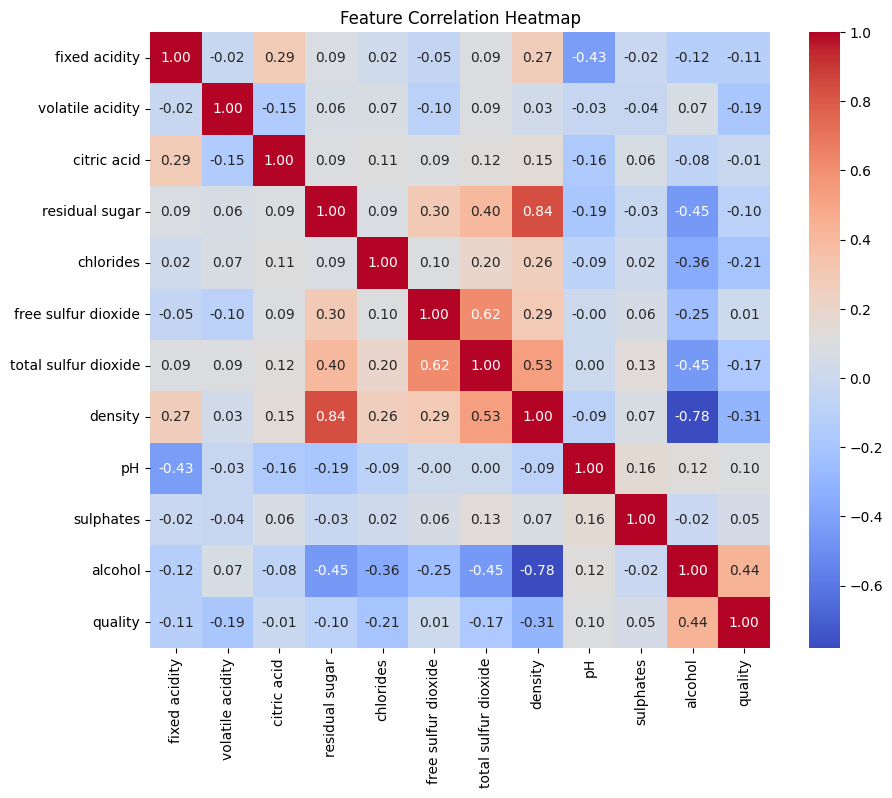

In [9]:
#I also want to see the correlation
plt.figure(figsize=(10, 8))
corr_matrix = ww_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [10]:
# I want to know which values effect quality the most, so i will try to find the correlation
corr = ww_df.corr()["quality"].abs().sort_values(ascending=False)
corr

quality                 1.000000
alcohol                 0.435575
density                 0.307123
chlorides               0.209934
volatile acidity        0.194723
total sulfur dioxide    0.174737
fixed acidity           0.113663
pH                      0.099427
residual sugar          0.097577
sulphates               0.053678
citric acid             0.009209
free sulfur dioxide     0.008158
Name: quality, dtype: float64

From this, it seems there is no single component with a very strong correlation, perhaps using PCA to find highest variances might reveal the most influential features. Or perhaps a random forest would help indentify which boundaries are the most important.

Intuitively, we can see that no particular element has a very linear correlation, the figure above for example, the tallest peak (total sulfure dioxide), increases and decreases. It may be possible that another feature makes up for what that one lacks i.e. A random example quality of 4, a high total sulfur dioxide and a low value for another feature may be a strong indicator.

This may be a hint, perhaps a linear correlation is NOT what we should be looking for, maybe whatever elements change the greatest across the qualities may related to the quality assignment?

So, i will now find which have the highest variation for each quality level, and also conduct ANOVA.

In [11]:
feature_variation = ww_df.groupby("quality").std()

mean_variation = feature_variation.mean().sort_values(ascending=False)
mean_variation

total sulfur dioxide    47.351149
free sulfur dioxide     23.795684
residual sugar           4.613689
alcohol                  1.108890
fixed acidity            1.005782
pH                       0.151285
sulphates                0.117040
volatile acidity         0.108465
citric acid              0.107445
chlorides                0.021515
density                  0.002791
dtype: float64

In [12]:
anova_results = {}
for feature in ww_df.columns[:-1]:
    groups = [ww_df[ww_df["quality"] == q][feature] for q in sorted(ww_df["quality"].unique())]
    f_stat, p_value = sci.stats.f_oneway(*groups)
    anova_results[feature] = (f_stat, p_value)

anova_df = pd.DataFrame(anova_results, index=["F-statistic", "p-value"]).T
anova_df = anova_df.sort_values(by="F-statistic", ascending=False)
print(anova_df)

                      F-statistic        p-value
alcohol                229.734772  2.925427e-259
density                105.856434  8.499687e-126
volatile acidity        61.916739   2.660979e-74
total sulfur dioxide    45.200949   4.044013e-54
chlorides               42.472252   8.504480e-51
residual sugar          21.270285   8.774192e-25
free sulfur dioxide     19.723674   7.013573e-23
fixed acidity           12.894792   1.638550e-14
pH                      10.103289   3.963648e-11
sulphates                3.642317   1.308437e-03
citric acid              3.245745   3.476298e-03


The ones at the top of both lists likely indicate they are influencing factors when it comes to the quality.
features to look out for in particular may be:
1. total sulfur dioxide - fairly high in both metrics
2. alochol -- extremely high F-statistic
3. density -- also extremely high in F-stat, but bottom in variation
The rest appear to be a mix, and density is still a hesitant choice for me, but I'd wager with such a high F-score its still meaningful.

In [13]:
# Now I will perform a linear regression manually -- I expect poor performance, but i want to know what the function is doing
# I'll first visualize what the matrix mulitplicaiton will look like using the 3 features above -- assuming a linear relationship
# y = w0 + w1 * x_tsul + w2 * x_alc + w3 * x_den
# Here i will prepare the test and training data

# CHANGE THIS TO SOMETHING OTHER THAN QUALITY -- LINEAR REGRESSION ILL SUITED FOR CLASSIFICATION
X = ww_df.drop(columns=["quality"])
y = ww_df["quality"]
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.3, random_state=20250326, stratify=ww_df["quality"])

feature_columns = ["total sulfur dioxide", "alcohol", "density"]
X_train_lin, X_test_lin = X_train[feature_columns].values, X_test[feature_columns].values
y_train_lin, y_test_lin = y_train.values, y_test.values
#verify shapes
print(f"X_train_lin shape: {X_train_lin.shape}, X_test_lin shape: {X_test_lin.shape}")
print(f"y_train_lin shape: {y_train_lin.shape}, y_test_lin shape: {y_test_lin.shape}")

y_train_lin = y_train_lin.reshape(-1, 1)
y_test_lin = y_test_lin.reshape(-1, 1)

# X_train_lin, X_test_lin = np.insert(X_train_lin, 0, 1, axis=1), np.insert(X_test_lin, 0, 1, axis=1)
# theta_lin = np.linalg.inv( X_train_lin.T @ X_train_lin ) @ X_train_lin.T @ y_train_lin
# b_lin, w_lin = theta_lin[0, 0], theta_lin[1, 0]
# print(theta_lin)

# # testing it
# y_pred_lin = X_test_lin @ theta_lin
# print(y_pred_lin)

# # Using a non-linear x-y relationship would yield a slightly more un-wieldy matrix of the form:
# # y = w0 + w1 * x_tsul + w2 * x_alc + w3 * x_den 	-- with the additional terms below
# #      + w4 * x_tsul ** 2 + w5 * x_alc ** 2 + w6 * x_den ** 2 + w7 * x_tsul * x_alc + w8 + x_tsul * x_den + w9 * x_den * x_alc
# #                                                                                                --- these bottom are interaction terms
# X_train_poly = skl.preprocessing.PolynomialFeatures(degree=2)

X_train_lin shape: (3428, 3), X_test_lin shape: (1470, 3)
y_train_lin shape: (3428,), y_test_lin shape: (1470,)


In [14]:
# A linear regression is ill suited for classification of the values of quality (3-9), i will attempt a logistic regression
# this will produce an error below since its not converging, which I'm not surprised by
log_reg = skl.linear_model.LogisticRegression(multi_class="multinomial", penalty='l2')
log_reg.fit(X_train_lin, y_train_lin)
y_pred_class = log_reg.predict(X_test_lin)

acc = skl.metrics.accuracy_score(y_test_lin, y_pred_class)
acc * 100

/Users/titanjuels/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/titanjuels/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/titanjuels/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation fo

46.59863945578231

In [15]:
# Very poor, as expected, the data has no sort of polynomial trends, even in higher powers
# This dataset may be suited for a decision tree or neural network.

#Neural Network
nn = skl.neural_network.MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100), alpha=0.00001, max_iter=1000, random_state=42)
nn.fit(X_train_lin, y_train_lin.ravel())
y_pred_nn = nn.predict(X_test_lin)
y_pred_train = nn.predict(X_train_lin)

nn_acc = skl.metrics.accuracy_score(y_test_lin, y_pred_nn)
print("NN ACC: " + str(nn_acc * 100))
nn_acc_train = skl.metrics.accuracy_score(y_train_lin, y_pred_train)
print("NN ACC on training set: " + str(nn_acc_train * 100))

#Decision Tree
tree = skl.tree.DecisionTreeClassifier(max_depth=10)
tree.fit(X_train_lin, y_train_lin.ravel())
y_pred_tree = tree.predict(X_test_lin)
y_pred_train_tree = tree.predict(X_train_lin)

tree_acc = skl.metrics.accuracy_score(y_test_lin, y_pred_tree)
print("Tree ACC: " + str(tree_acc * 100))
tree_acc_train = skl.metrics.accuracy_score(y_train_lin, y_pred_train_tree)
print("Tree ACC on training set: " + str(tree_acc_train * 100))

NN ACC: 46.53061224489796
NN ACC on training set: 46.032672112018666
Tree ACC: 52.6530612244898
Tree ACC on training set: 68.37806301050176


This is somewhat dissapointing, seeing a cool 97% accuracy would've been nice. But it does tell us something interesting about the data, perhaps its inherently random, but seeing performance is slightly better on the test set compared to the training set is odd, likely means there is still more progress for me to make in my ML journey 😅.

I'll try with the full dataframe, not the 'Top 3' features.

In [16]:
#Neural Network
nn_full = skl.neural_network.MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100), alpha=0.00001, max_iter=1000, random_state=42)
nn_full.fit(X_train, y_train)
y_pred_nn_full = nn_full.predict(X_test)
y_pred_train_full= nn_full.predict(X_train)

nn_acc = skl.metrics.accuracy_score(y_test, y_pred_nn_full)
print("NN ACC: " + str(nn_acc * 100))
nn_acc_train = skl.metrics.accuracy_score(y_train, y_pred_train_full)
print("NN ACC on training set: " + str(nn_acc_train * 100))

#Decision Tree
tree_full = skl.tree.DecisionTreeClassifier(max_depth=10)
tree_full.fit(X_train, y_train)
y_pred_tree_full = tree_full.predict(X_test)
y_pred_tree_train_full = tree_full.predict(X_train)

tree_acc = skl.metrics.accuracy_score(y_test, y_pred_tree_full)
print("Tree ACC: " + str(tree_acc * 100))
tree_acc_train = skl.metrics.accuracy_score(y_train, y_pred_tree_train_full)
print("Tree ACC on training set: " + str(tree_acc_train * 100))

NN ACC: 50.476190476190474
NN ACC on training set: 54.3465577596266
Tree ACC: 52.993197278911566
Tree ACC on training set: 73.33722287047841


Well its better than nothing, and it was a fun analysis. 

Now lets see if they're useful at all to differentiate between white and red, I like to think that it could have a future applicaion as a wine sommelier, but i feel there are easier, more 'visual' ways to differentiate white and red wine 😂.

### Below is predicting whether the wine is white or red

In [17]:
rw_df["type"] = 0
ww_df["type"] = 1
df = pd.concat([rw_df, ww_df])
assert len(df) == (len(rw_df) + len(ww_df))
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  type  
0      9.4        5     0  
1      9.8        5     0  
2      9.8        5     0  
3      9.8        6     0  
4      9.4        5     0

I'll create a validation, test, and training set.

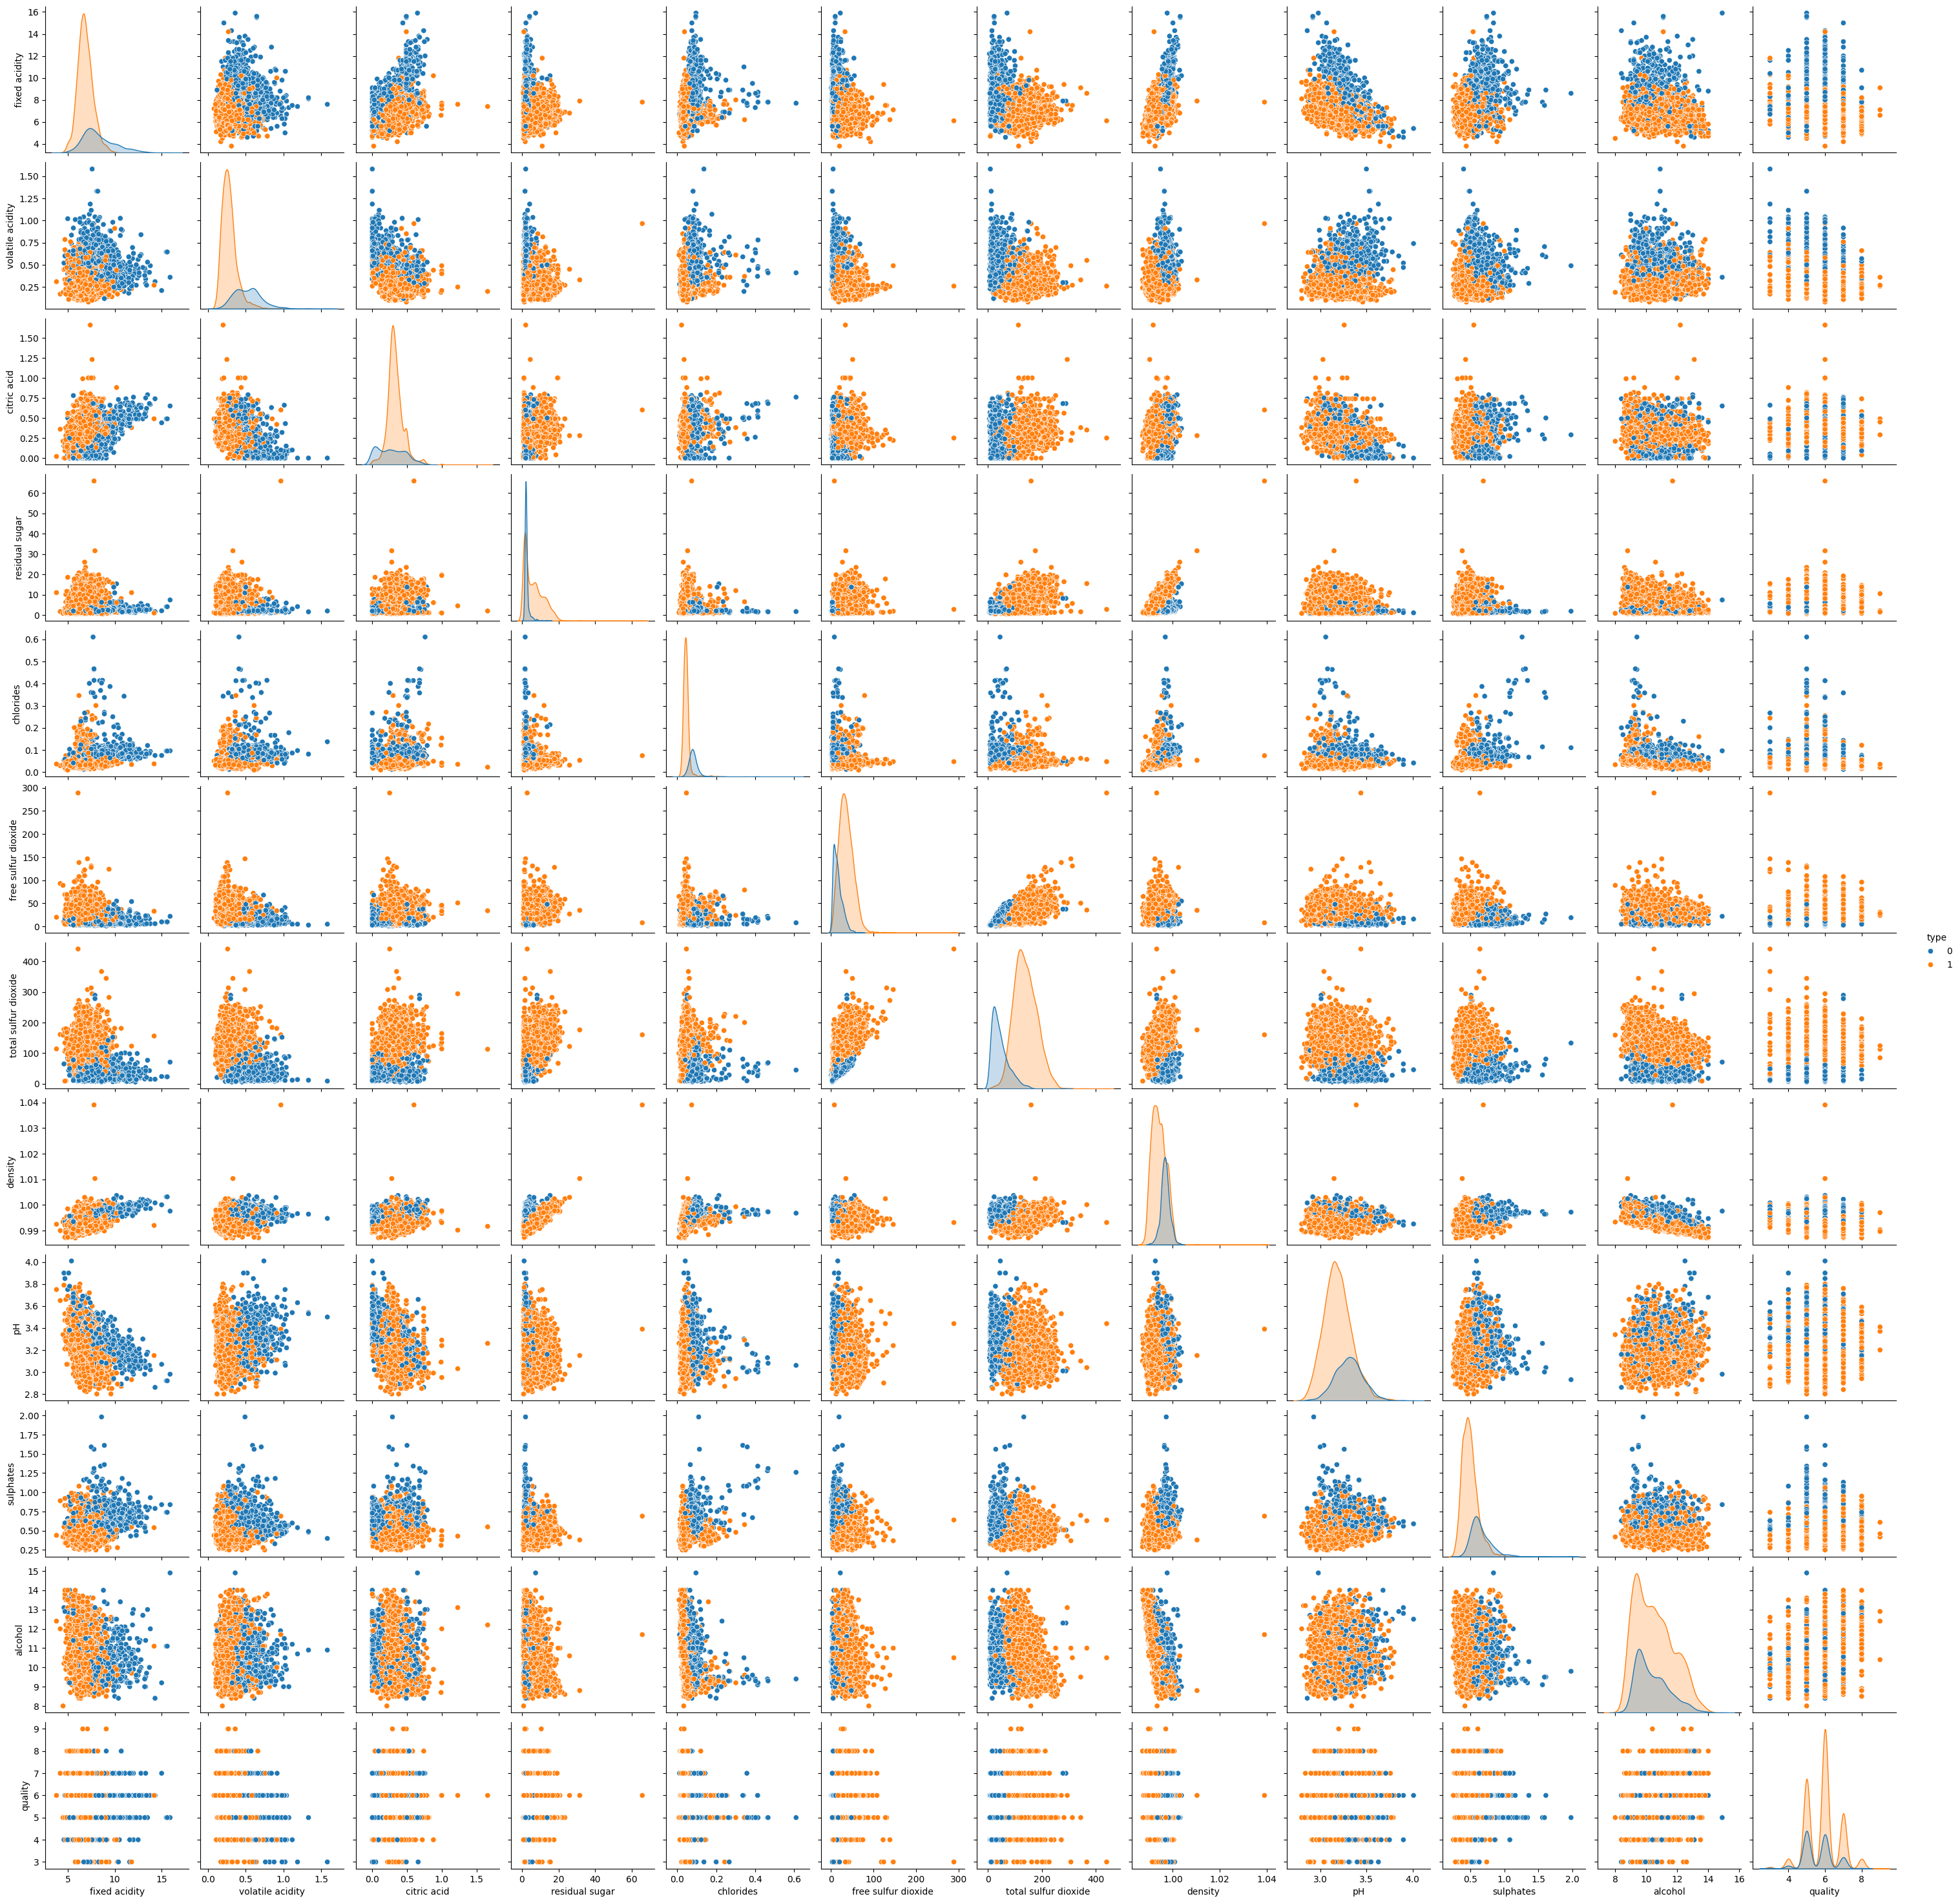

In [19]:
train_df_all, test_df_all = skl.model_selection.train_test_split(df, test_size=0.3, random_state=20250320, stratify=df["type"])
# val_df, test_df = skl.model_selection.train_test_split(temp_df, test_size=0.5, random_state=20250320, stratify=temp_df["type"])

sns.pairplot(train_df_all, hue="type")

Due to the number of data points, this was a bit of a struggle to plot... not to mention it seems a large majority of the plots have a high degree of overlap. But there are a few promising ones.
Going in order of what features seem to seperate the data well.
1. Fixed Acidity
2. Volatile acidity
3. total Sulfur Dioxide
4. alcohol
5. pH

Which means we'll be dropping; quality, sulphates, density, chlorides, free sulfur dioxide, chlorides, residual sugar, citric acid.

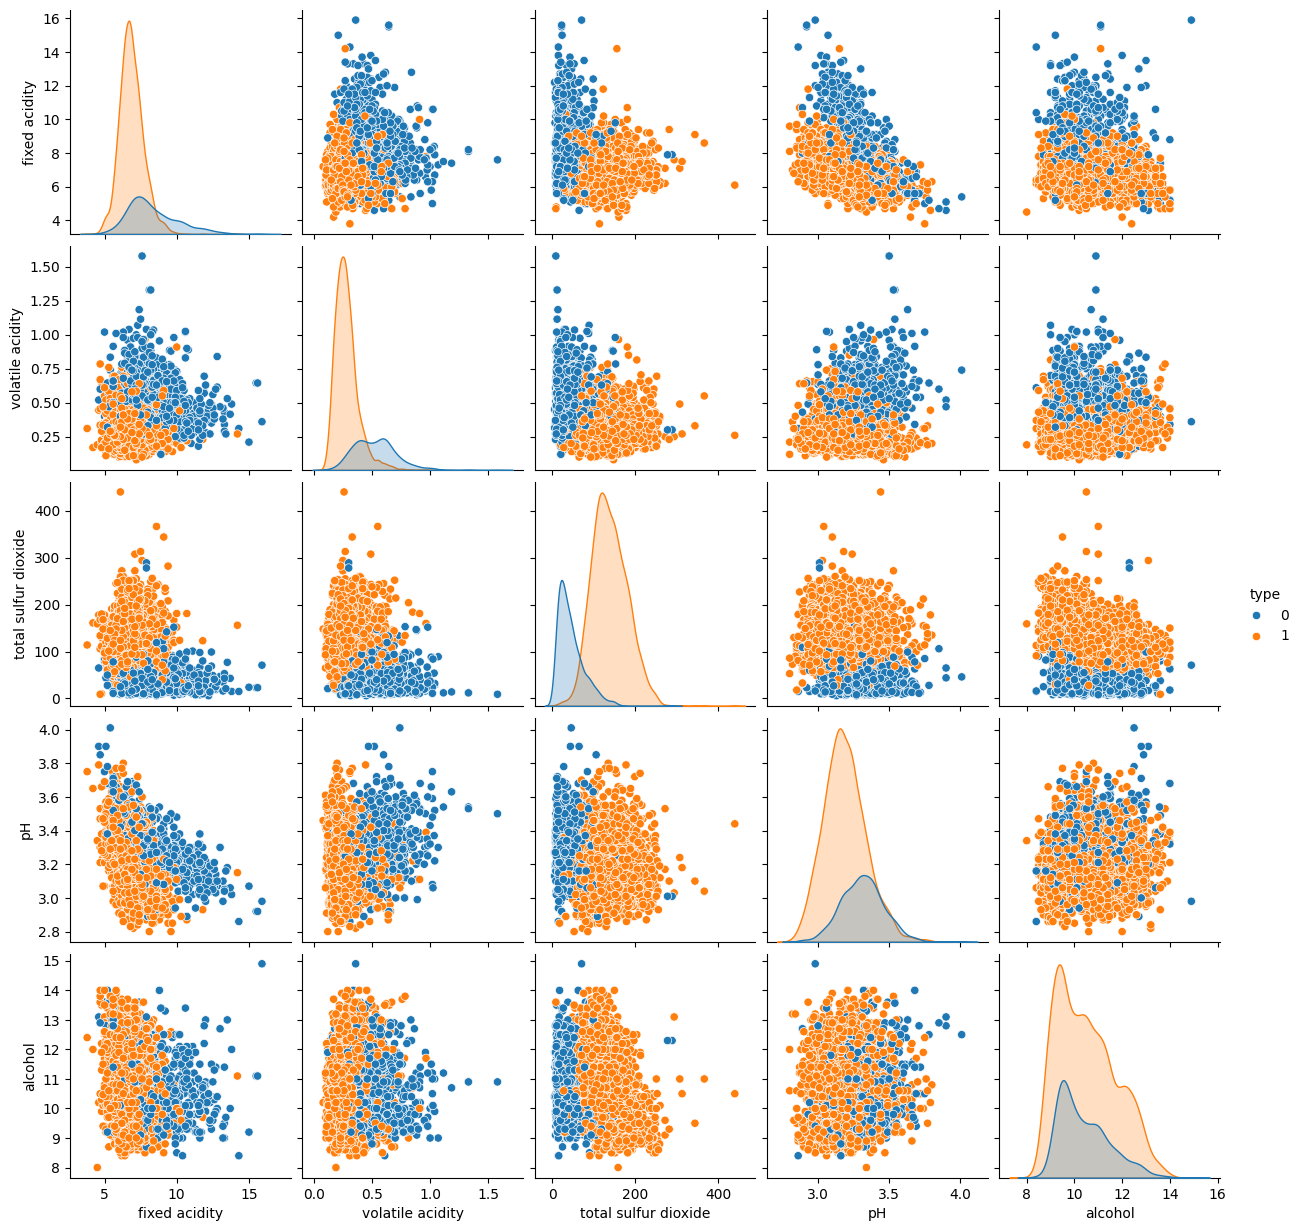

In [20]:
columns_to_drop = ["quality", "sulphates", "density", "chlorides", "free sulfur dioxide", "chlorides", "residual sugar", "citric acid"]
train_df = train_df_all.drop(columns=columns_to_drop)
# val_df = val_df.drop(columns=columns_to_drop)
test_df = test_df_all.drop(columns=columns_to_drop)

sns.pairplot(train_df, hue="type")

The final column is already enumerated as the type, so we can go ahead and seperate the X and y of the variables.

In [21]:
X_train, y_train = train_df.drop(columns=["type"]), train_df["type"]
# X_val, y_val = val_df.drop(columns=["type"]), val_df["type"]
X_test, y_test = test_df.drop(columns=["type"]), test_df["type"]

In [22]:
## Again this is yet another classification problem, meaning linear classification will probably still be an inefficient use case.
# So ill opt for a linear regression and try to implement it manually
def sigmoid(z):
    return np.exp(-np.logaddexp(0, -z))

def logistic_regression_gradient(xs_batch, ys_batch, w, b):
    assert len(xs_batch) == len(ys_batch), "Incompatible number of elements!"
    assert len(w) == xs_batch.shape[1], "Incompatible shape of parameter w!"

    predictions = sigmoid(np.dot(xs_batch, w) + b)
    error = predictions - ys_batch
    gradient_w = np.dot(xs_batch.T, error) / len(xs_batch)
    gradient_b = np.mean(error)
    
    return gradient_w, gradient_b

def logistic_manual(X, y, lr=0.01, epochs=100):
    m, n = X.shape
    theta = np.zeros(n)
    bias = 0

    for _ in range(epochs):
        g_w, g_b = logistic_regression_gradient(X, y, theta, bias)
        
        theta -= lr * g_w
        bias -= lr * g_b

    return theta, bias

theta, bias = logistic_manual(X_train, y_train)

# Predict function
def predict(X, theta, bias):
    return np.round(sigmoid(np.dot(X, theta) + bias))

y_pred_manual = predict(X_test, theta, bias)
accuracy = np.mean(y_pred_manual == y_test)
print(f"Manual Accuracy: {accuracy * 100:.2f}%")

Manual Accuracy: 84.10%


In [23]:
# Sklearn implementation
log_reg_clf = skl.linear_model.LogisticRegression(C=0.01)
log_reg_clf.fit(X_train, y_train)

skl_logreg_pred = log_reg_clf.predict(X_test)
acc = skl.metrics.accuracy_score(y_test, skl_logreg_pred)

print(f"Sklearn Accuracy: {acc * 100:.2f}%")

Sklearn Accuracy: 93.64%


Unsurprisingly, Sklearns implementation, which includes a lot more factors, is far better. But it's pretty cool to learn how it works behind the hood.

Trying random forest now, i want to see how runtime compares with these different implementations.

In [26]:
import time

### Lets see how it compares to a random forest
start_time = time.time()
rf_clf = skl.ensemble.RandomForestClassifier()
rf_clf.fit(X_train, y_train)
train_time = time.time() - start_time

start_time = time.time()
rf_pred = rf_clf.predict(X_test)
pred_time = time.time() - start_time

rf_acc = skl.metrics.accuracy_score(y_test, rf_pred)

print(f"Sklearn Random Forest Accuracy: {rf_acc * 100:.2f}%")
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {pred_time:.4f} seconds")

Sklearn Random Forest Accuracy: 98.46%
Training Time: 0.2229 seconds
Prediction Time: 0.0075 seconds


Now, i will compare to see if it was even meaningful to drop the columns, as this implementation ran fairly quickly on my machine, I'm curious to know how much better it performs (or slower it runs) with all the features 

In [29]:
X_train_all, y_train_all = train_df_all.drop(columns=["type"]), train_df_all["type"]
X_test_all, y_test_all = test_df_all.drop(columns=["type"]), test_df_all["type"]

start_time = time.time()
rf_clf_all = skl.ensemble.RandomForestClassifier()
rf_clf_all.fit(X_train_all, y_train_all)
train_time_all = time.time() - start_time

start_time = time.time()
rf_pred_all = rf_clf_all.predict(X_test_all)
pred_time_all = time.time() - start_time

rf_acc_all = skl.metrics.accuracy_score(y_test_all, rf_pred_all)

print(f"Sklearn Random Forest with all features Accuracy: {rf_acc_all * 100:.2f}%")
print(f"Training Time: {train_time_all:.4f} seconds")
print(f"Prediction Time: {pred_time_all:.4f} seconds")

Sklearn Random Forest with all features Accuracy: 99.38%
Training Time: 0.2801 seconds
Prediction Time: 0.0068 seconds


In [32]:
percent_delta = ((train_time_all - train_time) / train_time) * 100
print(f"Percentage change: {percent_delta:.2f}%")

Percentage change: -0.46%


Not too shappy, up to you whether its worth it given the extra runtime, but for real world use case vs testing, i'd imaging theres a big difference between 98.5% and 99.5%.